# <center> Microlocal analysis of the convolutional layers in LPD</center>

## Utilitary libraries

In [1]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import sys
sys.path.append("../../WF_inpaint/")

In [3]:
# Import the needed modules
from data.data_factory import random_realphantom
from ellipse.ellipseWF_factory import plot_WF, WFupdate, WFupdate_sino

import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import odl
import matplotlib.pyplot as plt

../../WF_inpaint/data/data_factory.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/homes/extern/andra

../../WF_inpaint/realphantom/realphantomWF_factory.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/ho

In [4]:
import os
import adler
adler.util.gpu.setup_one_gpu(0)

Warning, GPU setup must happen before importing ASTRA
Picking GPU 0


In [5]:
from adler.odl.phantom import random_phantom
from adler.tensorflow import prelu, cosine_decay

In [6]:
import tensorflow as tf
import numpy as np
import odl
import odl.contrib.tensorflow

In [7]:
np.random.seed(0)
#name = os.path.splitext(os.path.basename(__file__))[0]
name = os.path.splitext(os.getcwd())[0]+'/checkpoints'

In [8]:
sess = tf.InteractiveSession()

## Radon transform

In [9]:
size = 256
lowd = 40

In [10]:
from ray_transform.canon_relation import (point_img2sino, class_img2sino, CanRel_img2sino, 
                                         point_sino2img, CanRel_sino2img)

In [11]:
# Create ODL data structures
space = odl.uniform_discr([-int(size/2), -int(size/2)], [int(size/2), int(size/2)], [size, size],
                          dtype='float32')

In [12]:
# Full dose radon transform
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=180)
operator = odl.tomo.RayTransform(space, geometry)
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

In [13]:
# Low dose radon transform
geometry_lowd = odl.tomo.parallel_beam_geometry(space, num_angles=lowd)
operator_lowd = odl.tomo.RayTransform(space, geometry_lowd)
opnorm_lowd = odl.power_method_opnorm(operator_lowd)
operator_lowd = (1 / opnorm_lowd) * operator_lowd

## Data generator for CT recon

In [14]:
size = 256
nClasses = 180
lowd = 40
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)

In [15]:
batch_size = 5
n_iter = 10
n_primal = 5
n_dual = 5

In [16]:
def generate_data_CT(validation=False):
    """Generate a set of random data."""
    if validation:
        n_generate = 1
    else: 
        n_generate = batch_size

    y_arr = np.empty((n_generate, operator_lowd.range.shape[0], operator_lowd.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, nClasses)
        data = operator_lowd(phantom)
        noisy_data = data + odl.phantom.white_noise(operator_lowd.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr

In [17]:
y_arr, x_true_arr = generate_data_CT()

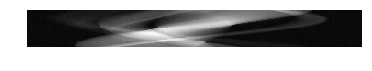

In [18]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(y_arr[0,:,:,0], cmap="gray")

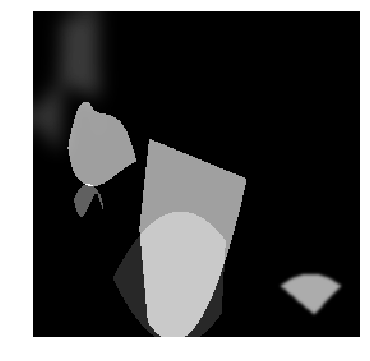

In [19]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(x_true_arr[0,:,:,0], cmap="gray")

## Evaluate primal dual

In [20]:
# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator_lowd,
                                                          'RayTransform')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator_lowd.adjoint,
                                                                  'RayTransformAdjoint')

In [21]:
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, size, size, 1], name="x_true")
    y_rt = tf.placeholder(tf.float32, shape=[None, operator_lowd.range.shape[0], operator_lowd.range.shape[1], 1], name="y_rt")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

In [22]:
def apply_conv(x, filters=32):
    return tf.layers.conv2d(x, filters=filters, kernel_size=3, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer(), use_bias=False)

In [23]:
relu = tf.nn.relu

In [24]:
primal_values = []
dual_values = []

In [25]:
with tf.name_scope('tomography'):
    with tf.name_scope('initial_values'):
        primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
        dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)

    for i in range(n_iter):
        with tf.variable_scope('dual_iterate_{}'.format(i)):
            evalop = odl_op_layer(primal[..., 1:2])
            update = tf.concat([dual, evalop, y_rt], axis=-1)

            #update = prelu(apply_conv(update), name='prelu_1')
            #update = prelu(apply_conv(update), name='prelu_2')
            update = relu(apply_conv(update), name='relu_1')
            update = relu(apply_conv(update), name='relu_2')            
            update = apply_conv(update, filters=n_dual)
            dual = dual + update

        with tf.variable_scope('primal_iterate_{}'.format(i)):
            evalop = odl_op_layer_adjoint(dual[..., 0:1])
            update = tf.concat([primal, evalop], axis=-1)

            update = relu(apply_conv(update), name='relu_1')
            update = relu(apply_conv(update), name='relu_2')
            update = apply_conv(update, filters=n_primal)
            primal = primal + update
        
        primal_values.append(primal)
        dual_values.append(dual)

    x_result = primal[..., 0:1]

In [26]:
# Initialize all TF variables
sess.run(tf.global_variables_initializer())

In [27]:
ckp_name = name+'_lpd_nobias/checkpoints'

In [28]:
adler.tensorflow.util.default_checkpoint_path(ckp_name)

'/store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Microcanonical_NN/Tensorflow_microlocal/checkpoints_lpd_nobias/checkpoints.ckpt'

In [29]:
# Add op to save and restore
saver = tf.train.Saver()

if 1:
    saver.restore(sess,
                  adler.tensorflow.util.default_checkpoint_path(ckp_name))

INFO:tensorflow:Restoring parameters from /store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Microcanonical_NN/Tensorflow_microlocal/checkpoints_lpd_nobias/checkpoints.ckpt


In [30]:
# Generate validation data
y_arr_validate, x_true_arr_validate = generate_data_CT(validation=True)

primal_values_result, dual_values_result = sess.run([primal_values, dual_values],
                      feed_dict={x_true: x_true_arr_validate,
                                 y_rt: y_arr_validate,
                                 is_training: False})

In [31]:
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

print(ssim(primal_values_result[-1][0, ..., 0], x_true_arr_validate[0, ..., 0]))
print(psnr(primal_values_result[-1][0, ..., 0], x_true_arr_validate[0, ..., 0], data_range=1))

0.986987719406
34.1344250283


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


## Taking a look on the different layers

(-0.5, 364.5, 39.5, -0.5)

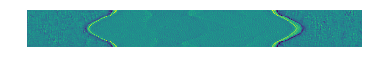

In [32]:
plt.figure(figsize=(6,6))
plt.imshow(dual_values_result[3][0, ..., 0])
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

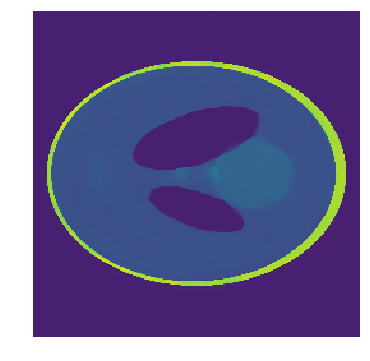

In [33]:
plt.figure(figsize=(6,6))
plt.imshow(primal_values_result[9][0, ..., 0])
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

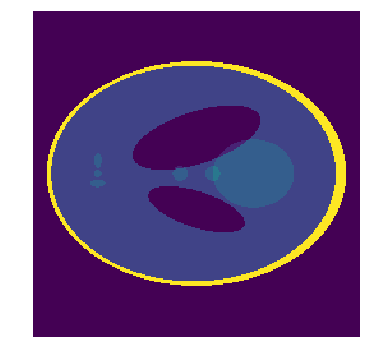

In [34]:
plt.figure(figsize=(6,6))
plt.imshow(x_true_arr_validate[0, ..., 0])
plt.axis('off')

## In this case we have 10 LPD conv_ResNet subnetworks representing each Dual/Primal step

List of variables

In [35]:
tf.global_variables()

[<tf.Variable 'dual_iterate_0/conv2d/kernel:0' shape=(3, 3, 7, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_0/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_0/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d/kernel:0' shape=(3, 3, 6, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d/kernel:0' shape=(3, 3, 7, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_1/conv2d/kernel:0' shape=(3, 3, 6, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_1/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable '

In [36]:
# Get access to the graph
gr = tf.get_default_graph()

First kernels in the dual step

In [37]:
kernels = gr.get_tensor_by_name('dual_iterate_0/conv2d/kernel:0').eval()

In [38]:
# The first convolutional layer is a concatenation of 7 convolutional layers, for the input values
# each one with 32 kernels
kernels.shape

(3, 3, 7, 32)

In [39]:
# The first kernel
n_dual_value = 0
channel = 0
kernel= kernels[:,:,n_dual_value,channel]

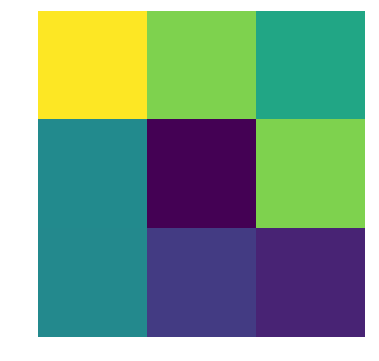

In [40]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(kernel)

### Approximation of the kernel with finite differences

### Finite differences matrices

In [41]:
D_11 = np.array([[0,0,0],[0, 1, 0], [0 , 0 , 0]])
D_12 = np.array([[0,1,0],[0, 0, 0], [0 , -1 , 0]])
D_21 = np.array([[0,0,0],[1, 0, -1], [0 , 0 , 0]])
D_22 = np.array([[1,0,-1],[0, 0, 0], [-1 , 0 , 1]])
D_13 = np.array([[0,-1,0],[0, 2, 0], [0 , -1 , 0]])
D_31 = np.array([[0,0,0],[1, -2, 1], [0 , 0 , 0]])
D_23 = np.array([[1,-2,1],[0, 0, 0], [-1 , 2 , -1]])
D_32 = np.array([[1,0,-1],[-2, 0, 2], [1 , 0 , -1]])
D_33 = np.array([[-1,2,-1],[2, -4, 2], [-1 , 2 , -1]])

In [42]:
D = [D_11, D_12, D_13, D_21, D_22, D_23, D_31, D_32, D_33]

### Change of variable

In [43]:
# Let us define the matrix for the change of coordinates
A = np.array([
    [0, 0, 0,  0, 1, 1, 0, 1, -1],
    [0, 1, -1, 0, 0, -2, 0, 0, 2],
    [0, 0, 0, 0, -1, 1, 0, -1, -1],
    [0, 0, 0, 1, 0, 0, 1, -2, 2],
    [1, 0, 2, 0, 0, 0, -2, 0, -4],
    [0, 0, 0, -1, 0, 0, 1, 2, 2],
    [0, 0, 0, 0, -1, -1, 0, 1, -1],
    [0, -1, -1, 0, 0, 2, 0, 0, 2],
    [0, 0, 0, 0, 1, -1, 0, -1, -1]
])

In [44]:
# Inverse
Ainv = np.linalg.inv(A)

### Coefficients

In [45]:
# Let us compute the flatten version of beta
Bflat = Ainv.dot(kernel.flatten())

In [46]:
B = Bflat.reshape(3,3);

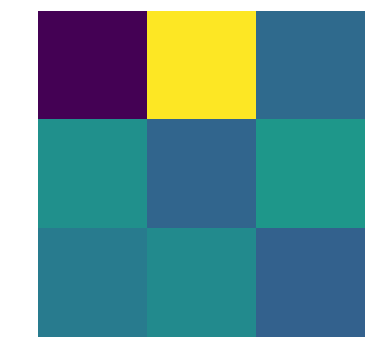

In [47]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(B)

### Reconstruction

In [48]:
kernel_recon = sum([Bflat[i]*D[i] for i in range(len(D))])

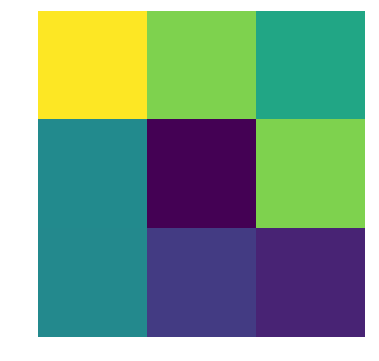

In [49]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(kernel_recon)

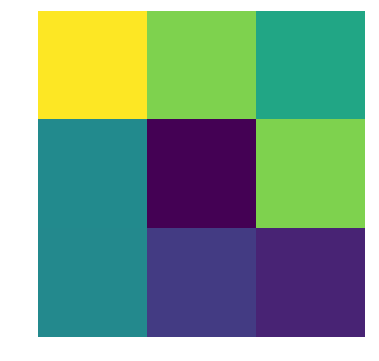

In [50]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(kernel)

### See if it gets the same values in the convolution

In [51]:
y_arr, x_true_arr = generate_data_CT()

In [52]:
kernel_tf = gr.get_tensor_by_name('dual_iterate_0/conv2d/kernel:0')[:,:,n_dual_value,channel:channel+1,np.newaxis]

In [53]:
inp = tf.constant(x_true_arr[0:1], dtype = tf.float32)

In [54]:
# Compute the result in tensorflow
tf_conv_out = tf.nn.conv2d(inp, kernel_tf,strides=[1, 1, 1, 1],padding='SAME').eval()[0,:,:,0]

In [55]:
from scipy.signal import convolve2d

In [56]:
scipy_conv_out = convolve2d(x_true_arr[0,:,:,0], kernel)

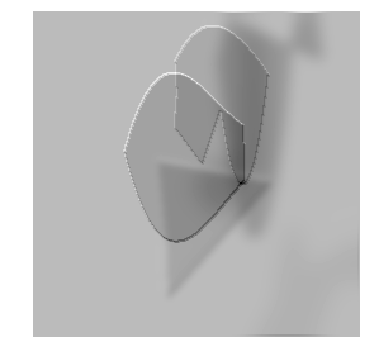

In [57]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(scipy_conv_out, cmap="gray")

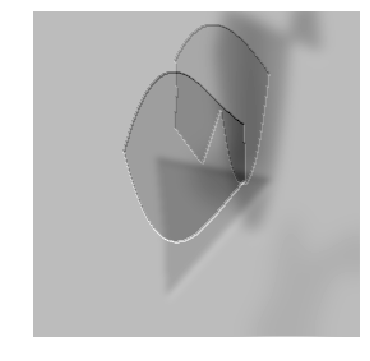

In [58]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(tf_conv_out, cmap="gray")

### Evaluate the ellipticity

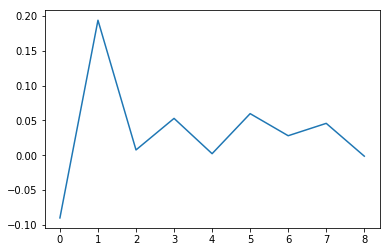

In [59]:
plt.plot(Bflat)

In [60]:
def pT(B, Xi): 
    p = (B[0,0]+B[0,1]*Xi[1]+B[1,0]*Xi[0]+B[1,1]*Xi[0]*Xi[1]+
        B[0,2]*Xi[1]**2+B[2,0]*Xi[1]**2+B[1,2]*Xi[0]*Xi[1]**2+
        B[2,1]*Xi[1]*Xi[0]**2+B[2,2]*(Xi[1]**2)*Xi[0]**2)
    return p

In [61]:
ellipt = np.array([pT(B,np.array([xi,yi])) for xi in range(size) for yi in range(size)]).reshape(size,size);

In [62]:
# The kernel is elliptic
np.min(np.abs(ellipt))

0.015727244317531586

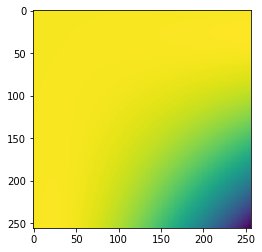

In [63]:
# Notice that the symbol acting on the fourier domain is killing the high frequencies
# meaning is smoothing out tha array
plt.imshow(ellipt)

### We can create a function that evaluates each convolutional layer and finds its ellipticity

In [64]:
names_variables = [variable.name for variable in tf.global_variables()]

In [65]:
# Convolutional variables
conv_variable = list(np.array(names_variables)[(list(map(lambda string: "conv" in string,names_variables)))])

In [66]:
name_layer = conv_variable[0]

In [67]:
# Getting kernels
kernels = gr.get_tensor_by_name(name_layer).eval()

In [68]:
# Let us define the matrix for the change of coordinates
A = np.array([
    [0, 0, 0,  0, 1, 1, 0, 1, -1],
    [0, 1, -1, 0, 0, -2, 0, 0, 2],
    [0, 0, 0, 0, -1, 1, 0, -1, -1],
    [0, 0, 0, 1, 0, 0, 1, -2, 2],
    [1, 0, 2, 0, 0, 0, -2, 0, -4],
    [0, 0, 0, -1, 0, 0, 1, 2, 2],
    [0, 0, 0, 0, -1, -1, 0, 1, -1],
    [0, -1, -1, 0, 0, 2, 0, 0, 2],
    [0, 0, 0, 0, 1, -1, 0, -1, -1]
])

In [69]:
def pT(B, Xi): 
    p = (B[0,0]+B[0,1]*Xi[1]+B[1,0]*Xi[0]+B[1,1]*Xi[0]*Xi[1]+
        B[0,2]*Xi[1]**2+B[2,0]*Xi[1]**2+B[1,2]*Xi[0]*Xi[1]**2+
        B[2,1]*Xi[1]*Xi[0]**2+B[2,2]*(Xi[1]**2)*Xi[0]**2)
    return p

In [70]:
Ainv_tf = tf.constant(Ainv, dtype = tf.float32)

Function that computes the ellipticity of the layer as the mean of the minimum values of the symbol in the corresponding (dual/primal) grid. We should implement this directly on tensorflow


In [71]:
def ellipt_layer_numpy(name_layer, Ainv):
    if "dual" in name_layer:
        shape = operator_lowd.range.shape
    else: 
        shape = operator_lowd.domain.shape
    kernels = gr.get_tensor_by_name(name_layer).eval()
    ellipts = []
    for n_value in range(kernels.shape[2]):
        for channel in range(kernels.shape[3]):
            kernel= kernels[:,:,n_value,channel]
            Bflat = Ainv.dot(kernel.flatten())
            B = Bflat.reshape(3,3);
            ellipts.append(np.min(np.abs(np.array([pT(B,np.array([xi,yi])) 
                                             for xi in range(shape[0]) for yi in 
                                             range(shape[1])]))));
    return np.mean(ellipts)

In [100]:
def ellipt_layer_tf(name_layer, Ainv_tf):
    if "dual" in name_layer:
        shape = operator_lowd.range.shape
    else: 
        shape = operator_lowd.domain.shape
    kernels = tf.transpose(gr.get_tensor_by_name(name_layer),[2,0,1,3])
    kernels_shape = kernels.shape
    kernels = tf.reshape(kernels, [kernels_shape[0],kernels_shape[1]*kernels_shape[2], kernels_shape[3]])
    Bflats = tf.tensordot(Ainv_tf,kernels, axes = [0,1])
    Bs = tf.reshape(Bflats,[3,3,kernels_shape[0], kernels_shape[3]]).eval()
    ellipts = []
    ellipts = []
    for n_value in range(Bs.shape[2]):
        for channel in range(Bs.shape[3]):
            B = Bs[:,:, n_value, channel]
            ellipts.append(np.min(np.abs(np.array([pT(B,np.array([xi,yi])) 
                                             for xi in range(shape[0]) for yi in 
                                             range(shape[1])]))));    
        return np.mean(ellipts)

In [101]:
import time

In [102]:
t = time.time()
ellipt_layer_numpy(name_layer, Ainv)
ellapsed_numpy = time.time()-t

In [104]:
t = time.time()
ellipt_layer_tf(name_layer, Ainv_tf)
ellapsed_tf = time.time()-t

In [105]:
ellapsed_numpy, ellapsed_tf

(18.209158658981323, 11.597294807434082)